# PARITY-DEPENDENT QUANTUM PHASE TRANSITION IN THE QUANTUM ISING CHAIN
## Numerical Simulation 
### Advanced Quantum Mechanics - Group: Antonio Francesco Mello, Asian Selvakumaran, Federico Raffaele De Filippi, Francesco Proietto

In [4]:
# importing libraries 
import numpy as np
from uncertainties import ufloat

# standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.providers.aer import AerSimulator
from qiskit.opflow import Z,I,X
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA,  COBYLA
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator 
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
import matplotlib.pyplot as plt

# noise model object
from qiskit.providers.aer.noise import NoiseModel
# standard errors
from qiskit.providers.aer.noise.errors import *  
# noise base classes
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError

## FUNCTIONS DEFINITION
### In the following cell we define the functions which will be used in the simulation

In [5]:
#function generating the hamiltonian for a TFIM with nn interaction J and field hf - PBC
def ham_generator(N,h,J):
    H=0
    
    # field term
    for i in range (N):
        H+= h*((I^(i))^(Z)^(I^(N-i-1))) 
    # interaction term
    for k in range(N-1):
        H+= J*((I^(k))^(X^X)^(I^(N-k-2)))
    # PBC
    H+= J*((X)^(I^(N-2))^(X))           
    return H         


#function that calculates the central difference derivative
# given npoints values of h in the interval [a,b[
def cd_derivative(a,b,en,npoints): 
    
    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    cd = (en[z+1]-en[z-1])/(2*step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h) in h = 0 >>', cd)
    return 

#function that calculates the forward derivative
def f_derivative(a,b,en,npoints):

    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    fd = (en[z+1]-en[z])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0+ >>', fd)
    return fd


#function that calculates the backward derivative
def b_derivative(a,b,en,npoints):

    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    bd = (en[z]-en[z-1])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0- >>', bd)
    return bd

#intermediate_info and callback function
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}



def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)


#function that clears the info contained in intermediate_info
def clear_info():
    info_f = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    return info_f

np.random.seed(7) #seed for reproducibility

## 1. N=5 chain (odd parity sector)
### 1a. Classical evaluation of the ground state energy
### 1b. Convergence study 
### 1c. VQE evaluation of the ground state energy

In [6]:
#parameters definition: number of spins, field and interaction term
nqubits=5
h=0.2
J=1.

In [7]:
# generate model hamiltonian 
H5=ham_generator(5,h,J)
print(H5)

0.2 * ZIIII
+ 0.2 * IZIII
+ 0.2 * IIZII
+ 0.2 * IIIZI
+ 0.2 * IIIIZ
+ 1.0 * XXIII
+ 1.0 * IXXII
+ 1.0 * IIXXI
+ 1.0 * IIIXX
+ 1.0 * XIIIX


In [5]:
# Classical evaluation of the ground state energy for the given parameters
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H5)
ref_value = result.eigenvalue.real
print('classical evaluation >> ',ref_value)

classical evaluation >>  -3.4500400835743306


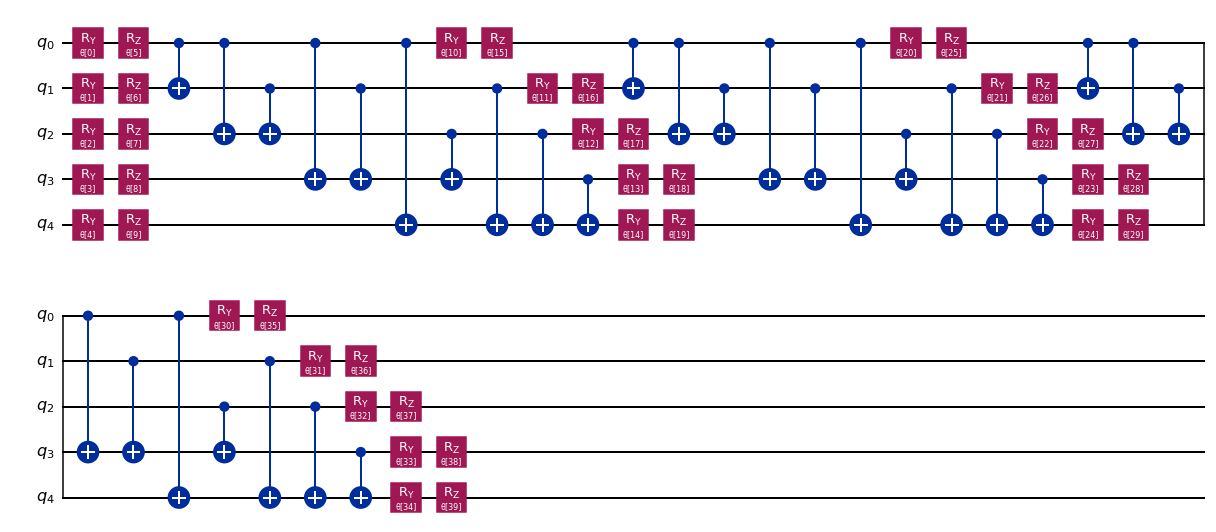

In [6]:
# We now turn to VQE evaluation of the ground state energy for the same Hamiltonian
# Hence we define the heuristic ansatz that will be used in the optimization routine
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
display(ansatz.decompose().draw('mpl', style='iqx')) 

Text(0, 0.5, 'GS energy')

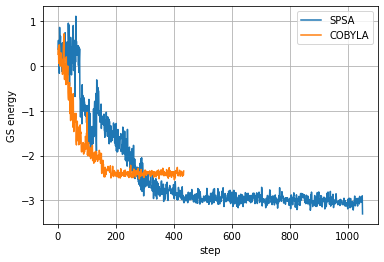

In [14]:
# OPTIMIZER STUDY: we proceed with the evaluation of the gs energy using two different optimizer in order to decide which one will be used in the following cells

optimizer = [SPSA(maxiter=500),COBYLA(maxiter=500)]
labels = ['SPSA','COBYLA']
initial_point = np.random.random(ansatz.num_parameters) # choose a random initial point in the parameter hyperspace

for i in range(np.size(optimizer)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=ansatz,
            optimizer=optimizer[i],
            initial_point=initial_point,
            quantum_instance=QasmSimulatorPy(),
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy = local_result.eigenvalue
    
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'],label=labels[i])
    plt.legend()

plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')

Text(0, 0.5, 'GS energy')

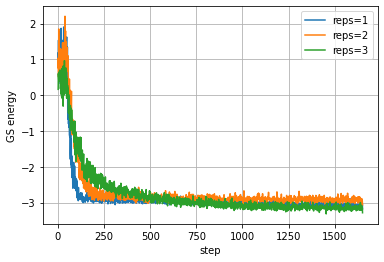

In [17]:
# REPS STUDY: we proceed with the evaluation of the gs energy with different reps in the ansatz
# in order to decide which one satisfies the best expressibility-trainability tradeoff
ansatz1=EfficientSU2(nqubits, reps=1, entanglement='full', insert_barriers=False) 
ansatz2=EfficientSU2(nqubits, reps=2, entanglement='full', insert_barriers=False) 
ansatz3=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
ansatze=[ansatz1,ansatz2,ansatz3]
labels=['reps=1','reps=2','reps=3']
optimizer =SPSA(maxiter=800)

initial_point = [np.random.random(ansatz1.num_parameters),np.random.random(ansatz2.num_parameters),np.random.random(ansatz3.num_parameters)]

for m in range(len(ansatze)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=ansatze[m],
            optimizer=optimizer,
            initial_point=initial_point[m],
            quantum_instance=QasmSimulatorPy(),
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy = local_result.eigenvalue
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'], label=labels[m])
    plt.legend()

plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')    

Text(0, 0.5, 'GS energy')

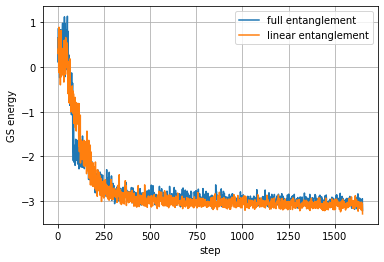

In [10]:
# ENTANGLEMENT STUDY: we proceed with the evaluation of the gs energy using linear and full entanglement in the ansatz
# in order to decide which one gives the best convergence
ansatz1=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
ansatz2=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=False) 
ansatze=[ansatz1,ansatz2]
labels=['full entanglement', 'linear entanglement']
optimizer =SPSA(maxiter=800)
initial_point = np.random.random(ansatz.num_parameters) 

for k in range(len(ansatze)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=ansatze[k],
            optimizer=optimizer,
            initial_point=initial_point,
            quantum_instance=QasmSimulatorPy(),
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy = local_result.eigenvalue
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'],label=labels[k])
    plt.legend()
    
plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')

In [16]:
# VQE EVALUATION FOR THE CHOSEN MAGNETIC FIELD: having chosen the ansatz with full entanglement and reps=3 we evaluate the gs energy
# in order to make a comparison with the classically evaluated one
optimizer = SPSA(maxiter=800)
initial_point = np.random.random(ansatz.num_parameters) 

intermediate_info=clear_info()

local_vqe = VQE(ansatz=ansatz,
         optimizer=optimizer,
         initial_point=initial_point,
         quantum_instance=QasmSimulatorPy(),
         callback=callback)

local_result = local_vqe.compute_minimum_eigenvalue(H5)
energy = local_result.eigenvalue
print('VQE evaluation of GS energy >>',ufloat(np.real(energy),intermediate_info['stddev'][-1]))

VQE evaluation of GS energy >> -3.221+/-0.020


### Before looking for the phase transition, we compare the GS energy evaluated with QasmSimulator and Statevector simulator 

GS energy evaluated with StateVector >>  (-3.3232468188265276+0j)


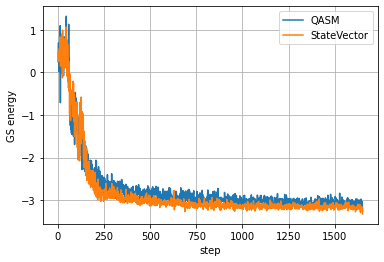

In [20]:
ansatz=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
simulator = Aer.get_backend('aer_simulator_statevector')
sims=[QasmSimulatorPy(),simulator]
labels=['QASM', 'StateVector']
optimizer =SPSA(maxiter=800)
initial_point = np.random.random(ansatz.num_parameters) # choose a random initial point in the parameter hyperspace

for k in range(len(sims)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=ansatz,
            optimizer=optimizer,
            initial_point=initial_point,
            quantum_instance=sims[k],
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy = local_result.eigenvalue
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'],label=labels[k])
    plt.legend()
    
plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')
print('GS energy evaluated with StateVector >> ', energy)

## 2. N=6 chain (even parity sector)
### 2a. Classical evaluation of the ground state energy
### 2b. Convergence study on the basis of: 
### 2c. VQE evaluation of the ground state energy

In [6]:
#parameters definition: nqubits, field and interaction term
nqubits=6
h=0.2
J=1.

In [7]:
# generate model hamiltonian
H6=ham_generator(6,h,J)
print(H6)

0.2 * ZIIIII
+ 0.2 * IZIIII
+ 0.2 * IIZIII
+ 0.2 * IIIZII
+ 0.2 * IIIIZI
+ 0.2 * IIIIIZ
+ 1.0 * XXIIII
+ 1.0 * IXXIII
+ 1.0 * IIXXII
+ 1.0 * IIIXXI
+ 1.0 * IIIIXX
+ 1.0 * XIIIIX


In [8]:
# Classical evaluation of the ground state energy for the given parameters
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H6)
ref_value = result.eigenvalue.real
print('classical evaluation >> ',ref_value)

classical evaluation >>  -6.060167024024


Text(0, 0.5, 'GS energy')

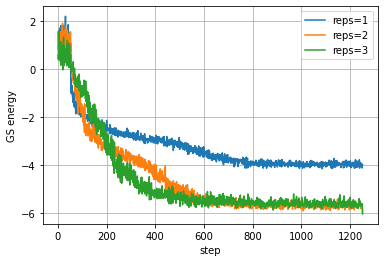

In [10]:
# REPS STUDY
ansatz1=EfficientSU2(nqubits, reps=1, entanglement='full', insert_barriers=False) 
ansatz2=EfficientSU2(nqubits, reps=2, entanglement='full', insert_barriers=False) 
ansatz3=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
ansatze=[ansatz1,ansatz2,ansatz3]
labels=['reps=1','reps=2','reps=3']
optimizer =SPSA(maxiter=600)

initial_point = [np.random.random(ansatz1.num_parameters),np.random.random(ansatz2.num_parameters),np.random.random(ansatz3.num_parameters)]

for m in range(len(ansatze)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=ansatze[m],
            optimizer=optimizer,
            initial_point=initial_point[m],
            quantum_instance=QasmSimulatorPy(),
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy = local_result.eigenvalue
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'], label=labels[m])
    plt.legend()

plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')


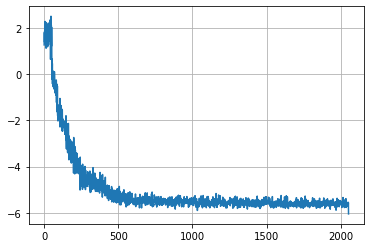

In [20]:
# We study the energy convergence to see if the iterations must be changed having increased nqubits

ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 
optimizer = SPSA(maxiter=1000)
initial_point = np.random.random(ansatz.num_parameters)

intermediate_info=clear_info()

local_vqe = VQE(ansatz=ansatz,
         optimizer=optimizer,
         initial_point=initial_point,
         quantum_instance=QasmSimulatorPy(),
         callback=callback)

local_result = local_vqe.compute_minimum_eigenvalue(H6)
energy = local_result.eigenvalue
plt.xlabel('step')
plt.ylabel('GS energy')
plt.grid()
plt.plot(intermediate_info['nfev'],intermediate_info['energy'])

In [21]:
# VQE EVALUATION with the associated standard deviation in order to compare it with the classical evaluation
print('VQE GS energy evaluation >>',energy, intermediate_info['stddev'][-1])

VQE GS energy evaluation >> (-6.04765625+0j) 0.023286242365804368


## 3. LOOKING FOR A PARITY-DEPENDENT PHASE TRANSITION
### 3a. GS energy evaluation with varying magnetic field
### 3b. Derivatives evaluation

/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2446719402.py:25: ComplexWarning: Casting complex values to real discards th

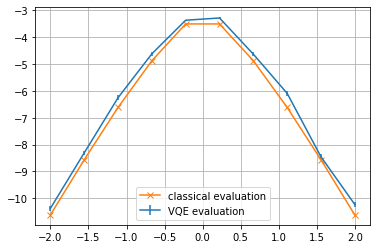

In [25]:
# VQE GS ENERGY EVALUATION WITH VARYING MAGNETIC FIELD: necessary in order to explore the GS energy in the neighbourhood of h=0 (where we expect the Quantum Phase Transition to emerge)
# ODD PARITY SECTOR
nqubits=5
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_5 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=500)


for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H5=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_5[j] = local_result.eigenvalue 
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h

plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.grid()
plt.errorbar(h,energy_5, yerr=y_err, label='VQE evaluation')


energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H5=ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H5)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='x', label = 'classical evaluation')
plt.legend()
plt.show()

/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/2025052027.py:24: ComplexWarning: Casting complex values to real discards th

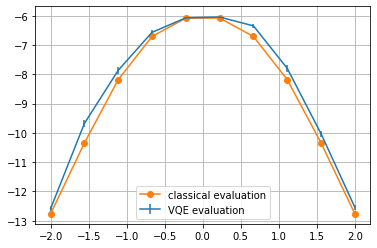

In [27]:
# EVEN PARITY SECTOR
nqubits=6
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False)
h = np.linspace(-2,2,10)
energy_6 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=500)


for j in range(np.size(h)):
    
    H6=ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy_6[j] = local_result.eigenvalue
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    
plt.errorbar(h,energy_6,yerr=y_err,label='VQE evaluation')
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H6 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H6)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show() 

In [28]:
# DERIVATIVES EVALUATION: we here evaluate the difference between the energy derivatives (for h->0+ and h->0-) to study the QPT
even_dx = f_derivative(-2,2,energy_6,10)
even_sx = b_derivative(-2,2,energy_6,10)
print('Even parity sector derivative >> ', even_dx-even_sx)
# in the even parity sector the derivative exists
even_d = cd_derivative(-2,2,energy_6,10)
print('Derivative in h=0',even_d)
odd_dx = f_derivative(-2,2,energy_5,10)
odd_sx = b_derivative(-2,2,energy_5,10)
print('Odd parity sector derivative >> ', odd_dx - odd_sx)

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -0.7552083333333348
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.0705295138888884
Even parity sector derivative >>  -0.8257378472222232
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h) in h = 0 >> -0.3423394097222232
Derivative in h=0 None
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -3.366970486111114
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.2061631944444442
Odd parity sector derivative >>  -3.573133680555558


/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/2257495963.py:25: ComplexWarning: Casting complex values to real discards th

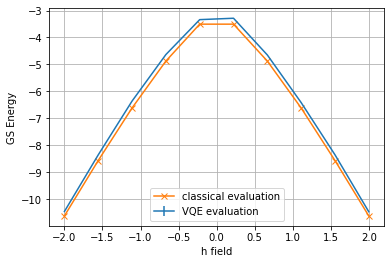

In [7]:
# STATEVECTOR SIMULATION: we here re-run our simulation using statevector simulator since it's faster and more accurate in convergence as seen from our previous study
# N=5
npme = NumPyMinimumEigensolver()
nqubits=5
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_5 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1000)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H5=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_5[j] = local_result.eigenvalue 
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h

plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.grid()
plt.errorbar(h,energy_5, yerr=y_err, label='VQE evaluation')

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H5=ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H5)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='x', label = 'classical evaluation')
plt.legend()
plt.show()

/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_6[j] = local_result.eigenvalue
/tmp/ipykernel_59/3562064950.py:24: ComplexWarning: Casting complex values to real discards th

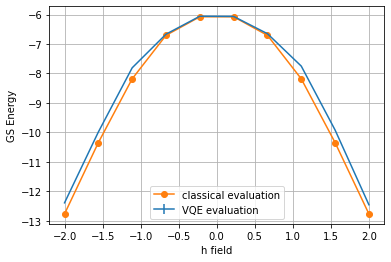

In [17]:
# STATEVECTOR SIMULATION N=6
nqubits=6
npme = NumPyMinimumEigensolver()
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False)
h = np.linspace(-2,2,10)
energy_6 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1000)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    H6 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy_6[j] = local_result.eigenvalue
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 

plt.xlabel('h field')
plt.ylabel('GS Energy')    
plt.errorbar(h,energy_6,yerr=y_err,label='VQE evaluation')
plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H6 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H6)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show() 

## 4. DERIVATIVES EVALUATION VARYING THE NUMBER OF SITES
### In the following cells we run the same simulation for chains of different length 

In [14]:
#4
nqubits=4
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_4 = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1000)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H4=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H4)
    energy_4[j] = local_result.eigenvalue 

#7
nqubits=7
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_7 = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1000)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H7=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H7)
    energy_7[j] = local_result.eigenvalue



/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/4112589860.py:23: ComplexWarning: Casting complex values to real discards th

In [22]:
#8
nqubits=8
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_8 = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1500)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H8=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H8)
    energy_8[j] = local_result.eigenvalue 

/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_8[j] = local_result.eigenvalue
/tmp/ipykernel_59/93435770.py:23: ComplexWarning: Casting complex values to real discards the imaginary pa

In [11]:
#9
nqubits=9
ansatz = EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=False) 

h = np.linspace(-2,2,10)
energy_9 = np.zeros(np.size(h))
 
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=1500)
simulator = Aer.get_backend('aer_simulator_statevector')

for j in range(np.size(h)):
    
    intermediate_info=clear_info()
    H9=ham_generator(nqubits,h[j],J)
    
    local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=simulator,
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H9)
    energy_9[j] = local_result.eigenvalue 

/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_9[j] = local_result.eigenvalue
/tmp/ipykernel_59/4167175411.py:23: ComplexWarning: Casting complex values to real discards th

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -0.9999257768617698
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.01399598884496367
-1.0139217657067334
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.4648826709531737
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -0.01671257941967097
-1.4481700915335027
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.8900615908496476
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -0.011310207280930129
-1.8787513835687175
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -3.40

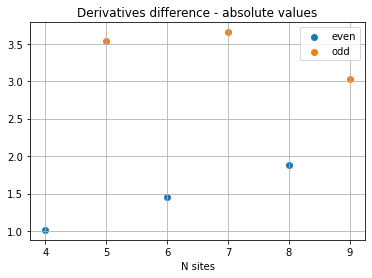

In [23]:
# DERIVATIVES CALCULATION for the chosen lengths

abs_global_even_d=[] # storage vector - even parity sector
abs_global_odd_d=[] # storage vector - odd parity sector

global_even_en=[energy_4,energy_6,energy_8]
global_odd_en=[energy_5,energy_7,energy_9]

for en in global_even_en:
    fd=f_derivative(-2,2,en,10)
    bd=b_derivative(-2,2,en,10)
    print(fd-bd)
    abs_global_even_d.append(abs(fd-bd))

for en in global_odd_en:
    fd=f_derivative(-2,2,en,10)
    bd=b_derivative(-2,2,en,10)
    print(fd-bd)
    abs_global_odd_d.append(abs(fd-bd))

plt.grid()
plt.xlabel('N sites')
plt.title('Derivatives difference - absolute values')
odd_sites=[5,7,9]
even_sites=[4,6,8]
plt.scatter(even_sites,abs_global_even_d,label='even')
plt.scatter(odd_sites,abs_global_odd_d,label='odd')
plt.legend()
plt.show()

## 5. NOISY SIMULATIONS
### 5a. Basic bit-flip noise model
### 5b. Thermal relaxation error
### 5c. Depolarizing noise channel
### 5d. IBM custom noise model

In [18]:
# BASIC BIT FLIP NOISE MODEL: this noise model introduces a basic pauli error on different instructions (reset, measure, rotations, cx)
# error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'u3', 'u1', 'reset', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Convergence study with full and linear entanglement and bit-flip 

Text(0, 0.5, 'GS energy')

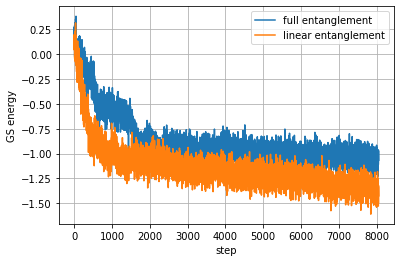

In [10]:
nqubits=5
sim_noise = AerSimulator(noise_model=noise_bit_flip)
ansatz1=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=True) 
ansatz2=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 
optimizer=SPSA(maxiter=4000)
labels=['full entanglement', 'linear entanglement']
transpiled_ansatz1=transpile(ansatz1, sim_noise)
transpiled_ansatz2=transpile(ansatz2, sim_noise)
transpiled_ansatze=[transpiled_ansatz1,transpiled_ansatz2]
initial_point = np.random.random(ansatz1.num_parameters)
for k in range(len(transpiled_ansatze)):
    
    intermediate_info=clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatze[k],
            optimizer=optimizer,
            initial_point=initial_point,
            quantum_instance=AerSimulator(noise_model=noise_bit_flip),
            callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy = local_result.eigenvalue
    plt.plot(intermediate_info['nfev'],intermediate_info['energy'],label=labels[k])
    plt.legend()
    
plt.grid()
plt.xlabel('step')
plt.ylabel('GS energy')

### As expected, full entanglement exhibits slower convergence being affected in a stronger way by this noise model

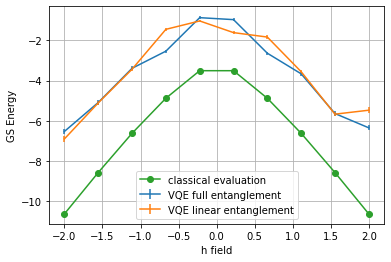

In [8]:
# Quantum Phase Transition Study - Bit flip noise simulation
# Odd parity sector
npme = NumPyMinimumEigensolver()
nqubits=5
sim_noise = AerSimulator(noise_model=noise_bit_flip)
ansatz1=EfficientSU2(nqubits, reps=3, entanglement='full', insert_barriers=True) 
ansatz2=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

labels=['VQE full entanglement', 'VQE linear entanglement']
transpiled_ansatz1=transpile(ansatz1, sim_noise)
transpiled_ansatz2=transpile(ansatz2, sim_noise)
transpiled_ansatze=[transpiled_ansatz1,transpiled_ansatz2]
h = np.linspace(-2,2,10)
energy_5=np.zeros((np.size(labels),np.size(h)))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz1.num_parameters)
optimizer=SPSA(maxiter=2000)

for k in range(len(transpiled_ansatze)):
    
    for j in range(np.size(h)):
    
        H5 = ham_generator(nqubits,h[j],J)
    
        clear_info()
    
        local_vqe = VQE(ansatz=transpiled_ansatze[k],
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=AerSimulator(noise_model=noise_bit_flip),
                    callback=callback)
        local_result = local_vqe.compute_minimum_eigenvalue(H5)
        energy_5[k][j] = np.real(local_result.eigenvalue)
        y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    plt.xlabel('h field')
    plt.ylabel('GS Energy')
    plt.errorbar(h,energy_5[k][:],yerr=y_err,label=labels[k])
plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H5 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H5)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show()

In [10]:
print('energy vector whit linear entanglement >>', energy_5[1][:])

energy vector whit linear entanglement >> [-6.89453125 -5.10677083 -3.43185764 -1.45182292 -1.03559028 -1.61501736
 -1.8359375  -3.55642361 -5.66536458 -5.46875   ]


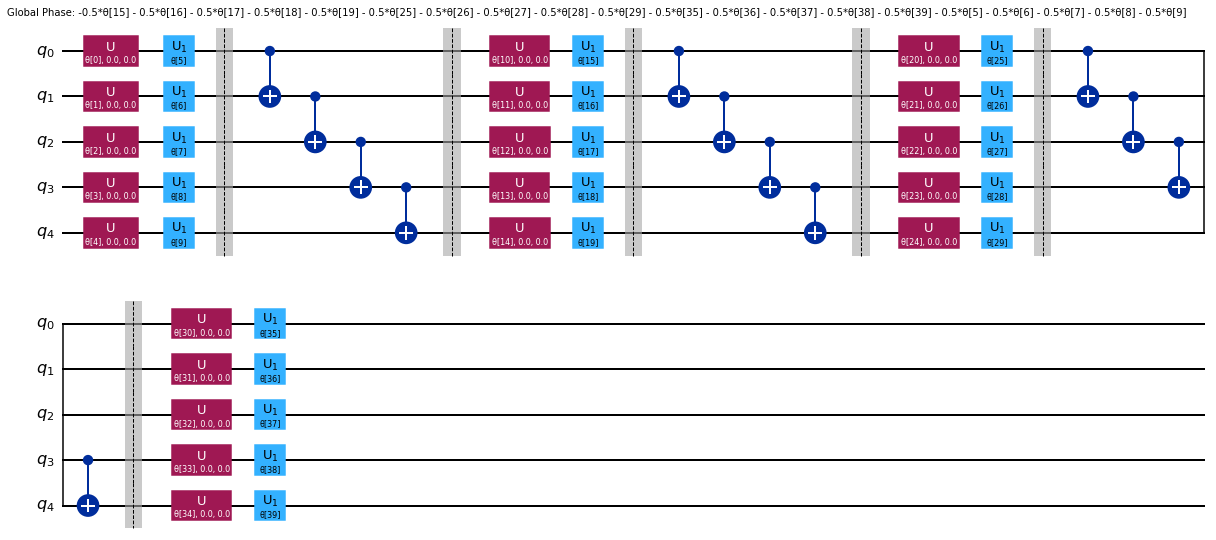

In [19]:
# figure - transpiled ansatz 
display(transpiled_ansatze[1].decompose().draw('mpl', style='iqx')) 

In [13]:
# EVEN PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=6
sim_noise = AerSimulator(noise_model=noise_bit_flip)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = np.linspace(-2,2,10)
energy_6 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(np.size(h)):
    
    H6 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=noise_bit_flip),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy_6[j] = np.real(local_result.eigenvalue)
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    


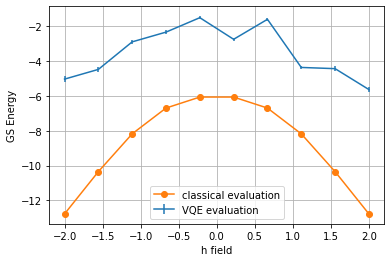

In [10]:
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_6,yerr=y_err,label='VQE evaluation')

plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H6 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H6)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show() 

In [11]:
print('energy vector>>', energy_6)

energy vector>> [-5.046875   -4.49001736 -2.91232639 -2.35416667 -1.52690972 -2.765625
 -1.62109375 -4.37803819 -4.44748264 -5.64453125]


In [12]:
# DERIVATIVES CALCULATION
even_dx = f_derivative(-2,2,energy_6,10)
even_sx = b_derivative(-2,2,energy_6,10)
print('Even parity sector derivative >> ', even_dx-even_sx)
odd_dx = f_derivative(-2,2,energy_5[1][:],10)
odd_sx = b_derivative(-2,2,energy_5[1][:],10)
print('Odd parity sector derivative >> ', odd_dx - odd_sx)

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> 2.861328125
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -3.0967882
Even parity sector derivative >>  5.958116325000001
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -0.5523003472222215
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -1.448567708333333
Odd parity sector derivative >>  0.8962673611111115


In [8]:
# DEPOLARIZING NOISE MODEL: this noise model introduces a depolarizing error on not and cx gate and pauli error on measures

def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

dep_noise=get_noise(0.003,0.05)
print(dep_noise)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx']
  All-qubits errors: ['measure', 'x', 'cx']


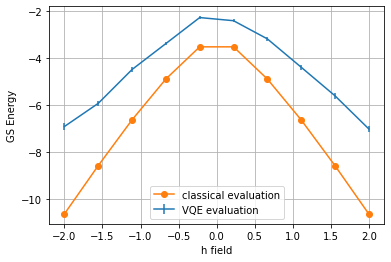

In [9]:
# Quantum Phase Transition Study - depolarizing noise simulation
# 0DD PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=5

sim_noise = AerSimulator(noise_model=dep_noise)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = np.linspace(-2,2,10)
energy_5 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(np.size(h)):
    
    H5 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=dep_noise),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_5[j] = np.real(local_result.eigenvalue)
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_5,yerr=y_err,label='VQE evaluation')

plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H5 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H5)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show()     

In [10]:
print('energy vector>>', energy_5)

energy vector>> [-6.8984375  -5.91276042 -4.47178819 -3.3671875  -2.25998264 -2.39366319
 -3.16666667 -4.37326389 -5.58940972 -7.        ]


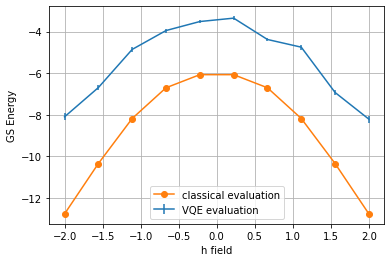

In [11]:
# EVEN PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=6

sim_noise = AerSimulator(noise_model=dep_noise)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = np.linspace(-2,2,10)
energy_6 = np.zeros(np.size(h))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(np.size(h)):
    
    H6 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=dep_noise),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy_6[j] = np.real(local_result.eigenvalue)
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_6,yerr=y_err,label='VQE evaluation')

plt.grid()

energy=np.zeros(np.size(h))
# classical evaluation of the ground state energy with varying magnetic field
# this is useful for a comparison of the convergence to the same result
for j in range(np.size(h)):
    H6 = ham_generator(nqubits,h[j],J)
    result=npme.compute_minimum_eigenvalue(operator=H6)
    energy[j]=result.eigenvalue.real
plt.plot(h,energy, marker='o', label = 'classical evaluation')

plt.legend()
plt.show()

In [12]:
print('energy vector>>', energy_6)

energy vector>> [-8.1015625  -6.6953125  -4.86067708 -3.953125   -3.51996528 -3.35677083
 -4.3828125  -4.75260417 -6.93098958 -8.21484375]


In [13]:
# DERIVATIVES CALCULATION
even_dx = f_derivative(-2,2,energy_6,10)
even_sx = b_derivative(-2,2,energy_6,10)
print('Even parity sector derivative >> ', even_dx-even_sx)
odd_dx = f_derivative(-2,2,energy_5,10)
odd_sx = b_derivative(-2,2,energy_5,10)
print('Odd parity sector derivative >> ', odd_dx - odd_sx)

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -2.5651041666666674
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.4079861111111116
Even parity sector derivative >>  -2.973090277777779
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.9325086805555536
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -0.3342013888888895
Odd parity sector derivative >>  -1.598307291666664


## SPECIFIC ERRORS TEST
### In the following cells, we study the effects produced by reset, measure and X gate errors on our capability of observing the quantum phase transition.
### In particular, we want to show that these errors have different effects (stronger or weaker influence) on the simulation.
### To this purpose, we run the simulation for each case with different error probabilities

In [10]:
# reset error
def noise_test_reset(p_res):
    error_reset = pauli_error([('X', p_res), ('I', 1 - p_res)])
    test_reset = NoiseModel()
    test_reset.add_all_qubit_quantum_error(error_reset, "reset")
    return test_reset 

In [6]:
print(noise_test_reset(0.2))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['reset']
  All-qubits errors: ['reset']


/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/1715714573.py:30: ComplexWarning: Cas

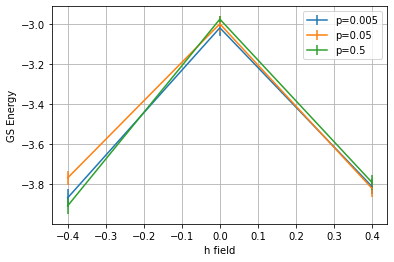

In [7]:
p_reset = [0.005, 0.05, 0.5]
nqubits=5
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 
labels=['p=0.005', 'p=0.05', 'p=0.5']

h = [-0.4,0.,0.4]
energy_5=np.zeros((len(labels),len(h)))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)
transpiled_ansatz1=transpile(ansatz, AerSimulator(noise_model=noise_test_reset(p_reset[0])))
transpiled_ansatz2=transpile(ansatz, AerSimulator(noise_model=noise_test_reset(p_reset[1])))
transpiled_ansatz3=transpile(ansatz, AerSimulator(noise_model=noise_test_reset(p_reset[2])))
transpiled_ansatze=[transpiled_ansatz1,transpiled_ansatz2,transpiled_ansatz3]

for k in range(len(p_reset)):
    
    for j in range(len(h)):
    
        H5 = ham_generator(nqubits,h[j],J)
    
        clear_info()
    
        local_vqe = VQE(ansatz=transpiled_ansatze[k],
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=AerSimulator(noise_model=noise_test_reset(p_reset[k])),
                    callback=callback)
        local_result = local_vqe.compute_minimum_eigenvalue(H5)
        energy_5[k][j] = local_result.eigenvalue
        y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    plt.xlabel('h field')
    plt.ylabel('GS Energy')
    plt.errorbar(h,energy_5[k][:],yerr=y_err,label=labels[k])
plt.grid()
plt.legend()
plt.show()

In [9]:
# DERIVATIVES EVALUATION
# p=0.005
odd_dx=(energy_5[0][2]-energy_5[0][1])/0.4
odd_sx=(energy_5[0][1]-energy_5[0][0])/0.4
print('Odd parity sector derivative p1 >> ', odd_dx - odd_sx)

#p=0.05
odd_dx=(energy_5[1][2]-energy_5[1][1])/0.4
odd_sx=(energy_5[1][1]-energy_5[1][0])/0.4
print('Odd parity sector derivative p2 >> ', odd_dx - odd_sx)

#p=0.5
odd_dx=(energy_5[2][2]-energy_5[2][1])/0.4
odd_sx=(energy_5[2][1]-energy_5[2][0])/0.4
print('Odd parity sector derivative p3 >> ', odd_dx - odd_sx)


Odd parity sector derivative p1 >>  -4.09375
Odd parity sector derivative p2 >>  -3.966796874999999
Odd parity sector derivative p3 >>  -4.357421875


In [19]:
# X gates error
def noise_test_gates(p_gat):
    error_gate1 = pauli_error([('X',p_gat), ('I', 1 - p_gat)])
    error_gate2 = error_gate1.tensor(error_gate1)
    test_gates = NoiseModel()
    test_gates.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    test_gates.add_all_qubit_quantum_error(error_gate2, ["cx"])
    return test_gates

In [20]:
print(noise_test_gates(0.2))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2', 'cx']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_10506/306895167.py:30: ComplexWarning: Casting co

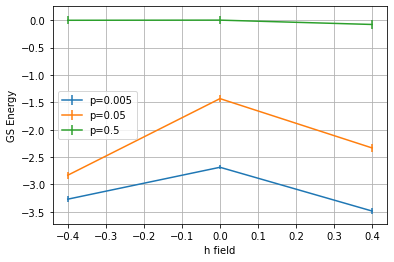

In [21]:
p_gates = [0.005, 0.05, 0.5]
nqubits=5
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 
labels=['p=0.005', 'p=0.05', 'p=0.5']

h = [-0.4,0.,0.4]
energy_5=np.zeros((len(labels),len(h)))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)
transpiled_ansatz1=transpile(ansatz, AerSimulator(noise_model=noise_test_gates(p_gates[0])))
transpiled_ansatz2=transpile(ansatz, AerSimulator(noise_model=noise_test_gates(p_gates[1])))
transpiled_ansatz3=transpile(ansatz, AerSimulator(noise_model=noise_test_gates(p_gates[2])))
transpiled_ansatze=[transpiled_ansatz1,transpiled_ansatz2,transpiled_ansatz3]

for k in range(len(p_gates)):
    
    for j in range(len(h)):
    
        H5 = ham_generator(nqubits,h[j],J)
    
        clear_info()
    
        local_vqe = VQE(ansatz=transpiled_ansatze[k],
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=AerSimulator(noise_model=noise_test_gates(p_gates[k])),
                    callback=callback)
        local_result = local_vqe.compute_minimum_eigenvalue(H5)
        energy_5[k][j] = local_result.eigenvalue
        y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    plt.xlabel('h field')
    plt.ylabel('GS Energy')
    plt.errorbar(h,energy_5[k][:],yerr=y_err,label=labels[k])
plt.grid()
plt.legend()
plt.show()

In [22]:
# DERIVATIVES EVALUATION
# p=0.005
odd_dx=(energy_5[0][2]-energy_5[0][1])/0.4
odd_sx=(energy_5[0][1]-energy_5[0][0])/0.4
print('Odd parity sector derivative p1 >> ', odd_dx - odd_sx)

#p=0.05
odd_dx=(energy_5[1][2]-energy_5[1][1])/0.4
odd_sx=(energy_5[1][1]-energy_5[1][0])/0.4
print('Odd parity sector derivative p2 >> ', odd_dx - odd_sx)

#p=0.5
odd_dx=(energy_5[2][2]-energy_5[2][1])/0.4
odd_sx=(energy_5[2][1]-energy_5[2][0])/0.4
print('Odd parity sector derivative p3 >> ', odd_dx - odd_sx)

Odd parity sector derivative p1 >>  -3.4550781250000018
Odd parity sector derivative p2 >>  -5.75
Odd parity sector derivative p3 >>  -0.20507812500000025


In [8]:
# measure error
def noise_test_measure(p_mea):
    error_meas = pauli_error([('X', p_mea), ('I', 1 - p_mea)])
    test_measure = NoiseModel()
    test_measure.add_all_qubit_quantum_error(error_meas, "measure")
    return test_measure 

In [9]:
print(noise_test_measure(0.2))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']


/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[k][j] = local_result.eigenvalue
/tmp/ipykernel_59/1272007145.py:30: ComplexWarning: Casting complex values t

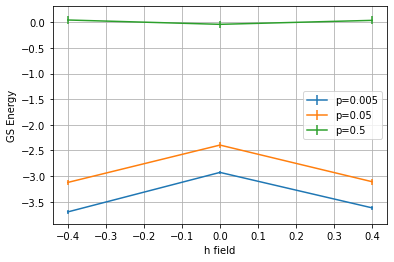

In [11]:
p_meas = [0.005, 0.05, 0.5]
nqubits=5
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 
labels=['p=0.005', 'p=0.05', 'p=0.5']

h = [-0.4,0.,0.4]
energy_5=np.zeros((len(labels),len(h)))
y_err = np.zeros(np.size(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)
transpiled_ansatz1=transpile(ansatz, AerSimulator(noise_model=noise_test_measure(p_meas[0])))
transpiled_ansatz2=transpile(ansatz, AerSimulator(noise_model=noise_test_measure(p_meas[1])))
transpiled_ansatz3=transpile(ansatz, AerSimulator(noise_model=noise_test_measure(p_meas[2])))
transpiled_ansatze=[transpiled_ansatz1,transpiled_ansatz2,transpiled_ansatz3]

for k in range(len(p_meas)):
    
    for j in range(len(h)):
    
        H5 = ham_generator(nqubits,h[j],J)
    
        clear_info()
    
        local_vqe = VQE(ansatz=transpiled_ansatze[k],
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=AerSimulator(noise_model=noise_test_measure(p_meas[k])),
                    callback=callback)
        local_result = local_vqe.compute_minimum_eigenvalue(H5)
        energy_5[k][j] = local_result.eigenvalue
        y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
    plt.xlabel('h field')
    plt.ylabel('GS Energy')
    plt.errorbar(h,energy_5[k][:],yerr=y_err,label=labels[k])
plt.grid()
plt.legend()
plt.show()

In [ ]:
# DERIVATIVES EVALUATION
# p=0.005
odd_dx=(energy_5[0][2]-energy_5[0][1])/0.4
odd_sx=(energy_5[0][1]-energy_5[0][0])/0.4
print('Odd parity sector derivative p1 >> ', odd_dx - odd_sx)

#p=0.05
odd_dx=(energy_5[1][2]-energy_5[1][1])/0.4
odd_sx=(energy_5[1][1]-energy_5[1][0])/0.4
print('Odd parity sector derivative p2 >> ', odd_dx - odd_sx)

#p=0.5
odd_dx=(energy_5[2][2]-energy_5[2][1])/0.4
odd_sx=(energy_5[2][1]-energy_5[2][0])/0.4
print('Odd parity sector derivative p3 >> ', odd_dx - odd_sx)

Odd parity sector derivative p1 >>  -3.656250000000001
Odd parity sector derivative p2 >>  -3.609375
Odd parity sector derivative p3 >>  0.40429687499999983


## 6. VQD EVALUATION
### 6a. 1st excited state energy evaluation with N=5, N=6
### 6b. Looking for reminiscence of the qpt

In [59]:
# necessary libraries for VQD
from qiskit.algorithms.eigensolvers import VQD
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.eigensolvers import NumPyEigensolver

In [60]:
# function generating system hamiltonian N=5,PBC
def ham5_generator(h,J):
    H = SparsePauliOp.from_list(
        [
            ("ZIIII", h),
            ("IZIII", h),
            ("IIZII", h),
            ("IIIZI", h),
            ("IIIIZ", h),
            ("XXIII", J),
            ("IXXII", J),
            ("IIXXI", J),
            ("IIIXX", J),
            ("XIIIX", J),
        ]
    )
    return H

# function generating system hamiltonian N=6,PBC
def ham6_generator(h,J):
    H = SparsePauliOp.from_list(
        [
            ("ZIIIII", h),
            ("IZIIII", h),
            ("IIZIII", h),
            ("IIIZII", h),
            ("IIIIZI", h),
            ("IIIIIZ", h),
            ("XXIIII", J),
            ("IXXIII", J),
            ("IIXXII", J),
            ("IIIXXI", J),
            ("IIIIXX", J),
            ("XIIIIX", J),
        ]
    )
    return H

# new intermediate_info for VQD
intermediate_info = {
    'eval_count': [],
    'params': [],
    'energy': [],
    'metadata': [],
    'curr_step': []
}


# function initializing intermediate_info
def clear_info_vqd():
    info_f = {
        'eval_count': [],
        'params': [],
        'energy': [],
        'metadata': [],
        'curr_step': []
    }
    return info_f

# new callback function for VQD
def callback_vqd(eval_count, parameters, energy, meta, step):
    intermediate_info['eval_count'].append(eval_count)
    intermediate_info['params'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['metadata'].append(meta)
    intermediate_info['curr_step'].append(step)
    


In [61]:
nqubits=5
# circuit that reproduces the ansatz wavefunction
ansatz = EfficientSU2(nqubits, reps=2, entanglement='linear', insert_barriers=True) 
#display(ansatz.decompose().draw('mpl', style='iqx'))  

optimizer=SLSQP(maxiter=100)
ansatz.decompose().draw('mpl')
initial_point = np.random.random(ansatz.num_parameters) 

estimator = Estimator() # primtiive for expectation values
sampler = Sampler() # primitive for overlaps
fidelity = ComputeUncompute(sampler)

k = 2 # number of energy eigenstates we want
betas = [33, 33] # lagrange multipliers

h=np.linspace(-2,2,10)
exact_solver = NumPyEigensolver(k=2) 
ref_values = []
vqd_values = []

for j in range(np.size(h)):
    
    clear_info_vqd()
    
    H=ham5_generator(h[j],J)
    
    exact_result = exact_solver.compute_eigenvalues(PauliSumOp(H))
    ref_values.append(exact_result.eigenvalues)
    
    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback_vqd)
    result = vqd.compute_eigenvalues(operator = H)
    vqd_values.append(result.optimal_values)
    print('Iteration >>',j+1)
   

Iteration >> 1
Iteration >> 2
Iteration >> 3
Iteration >> 4
Iteration >> 5
Iteration >> 6
Iteration >> 7
Iteration >> 8
Iteration >> 9
Iteration >> 10


[[-10.49716989  -7.86268399]
 [ -8.10972374  -6.67151942]
 [ -6.43850339  -5.44541977]
 [ -4.64785576  -4.40886759]
 [ -3.41501803  -3.43694244]
 [ -3.38215133  -3.35469952]
 [ -4.57163706  -4.34055237]
 [ -6.55735637  -5.33192033]
 [ -8.40714524  -6.69799107]
 [-10.49597881  -7.59307129]]


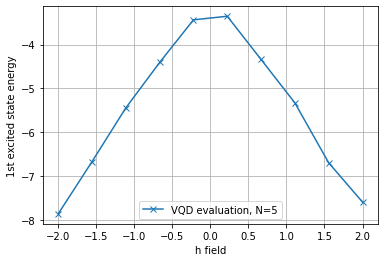

In [85]:
exc_energy=np.zeros(np.size(h))
for k in range(np.size(h)):
    exc_energy[k]=vqd_values[k][1]
    
plt.xlabel('h field')
plt.ylabel('1st excited state energy')
plt.grid()
plt.plot(h,exc_energy, marker='x', label='VQD evaluation, N=5')
plt.legend()

print(np.array(vqd_values))

In [87]:
nqubits=6
# circuit that reproduces the ansatz wavefunction
ansatz = EfficientSU2(nqubits, reps=2, entanglement='linear', insert_barriers=True) 
#display(ansatz.decompose().draw('mpl', style='iqx'))  

optimizer=SLSQP(maxiter=100)
ansatz.decompose().draw('mpl')
initial_point = np.random.random(ansatz.num_parameters) 

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

k = 2
betas = [33, 33]

h=np.linspace(-2,2,10)
exact_solver = NumPyEigensolver(k=2) #k is the number of eigenvalues we want
ref_values = []
vqd_values = []

for j in range(np.size(h)):
    
    clear_info_vqd()
    
    H=ham6_generator(h[j],J)
    
    exact_result = exact_solver.compute_eigenvalues(PauliSumOp(H))
    ref_values.append(exact_result.eigenvalues)
    
    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback_vqd)
    result = vqd.compute_eigenvalues(operator = H)
    vqd_values.append(result.optimal_values)

[[-12.62894179  -9.91075891]
 [-10.16118714  -9.11030492]
 [ -7.93195843  -7.85321609]
 [ -6.67617168  -5.44270425]
 [ -6.07409685  -6.07417369]
 [ -6.07427604  -6.07416152]
 [ -6.67900864  -6.68189096]
 [ -7.92598614  -7.8999253 ]
 [-10.02038959  -8.42091707]
 [-12.37484651 -10.08085278]]


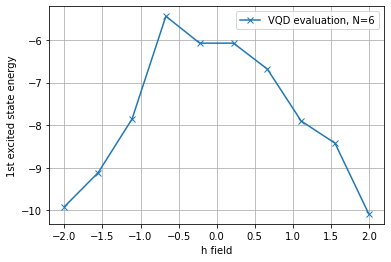

In [88]:
exc_energy6=np.zeros(np.size(h))
for k in range(np.size(h)):
    exc_energy6[k]=vqd_values[k][1]
    
plt.xlabel('h field')
plt.ylabel('1st excited state energy')
plt.grid()
plt.plot(h,exc_energy6, marker='x', label='VQD evaluation, N=6')
plt.legend()

print(np.array(vqd_values))

In [90]:
# DERIVATIVES CALCULATION
even_dx = f_derivative(-2,2,exc_energy6,10)
even_sx = b_derivative(-2,2,exc_energy6,10)
print('Even parity sector derivative >> ', even_dx-even_sx)
odd_dx = f_derivative(-2,2,exc_energy,10)
odd_sx = b_derivative(-2,2,exc_energy,10)
print('Odd parity sector derivative >> ', odd_dx - odd_sx)

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.5193235983058595
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 3.0404918776039125e-05
Even parity sector derivative >>  -1.5193540032246355
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -2.464632117082036
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.20560728342983614
Odd parity sector derivative >>  -2.670239400511872
